In [20]:
%run _bootstrap.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# 1️⃣  ────────────────────────────────────────────────────────────────────────
# Core project imports
# ----------------------------------------------------------------------------
import numpy as np
import pandas as pd

from src.signal_logic import signal_from_zscore
from src.backtest import run_backtest
from src.metrics import sharpe_ratio, max_drawdown

In [22]:
# 2️⃣  ────────────────────────────────────────────────────────────────────────
# Build a *synthetic* 5-minute BTC-style price series (geometric Brownian motion)
# ----------------------------------------------------------------------------
np.random.seed(7)

N_BARS = 2_500  # ~ 8.5 days of 5-min data
FREQ = "5min"
MU, SIGMA = 0.00, 0.04  # drift , vol per √day
DT = 1 / (24 * 12)  # fraction of a day for 5-min bar

dW = np.random.normal(scale=np.sqrt(DT), size=N_BARS)
log_path = np.cumsum((MU - 0.5 * SIGMA**2) * DT + SIGMA * dW)
price_series = np.exp(log_path) * 28_000  # start ~28k

idx = pd.date_range("2024-01-01", periods=N_BARS, freq=FREQ)
df = pd.DataFrame({"open": price_series}, index=idx)

In [23]:
# 3️⃣  ────────────────────────────────────────────────────────────────────────
# Feature engineering – log return + rolling Z-score
# ----------------------------------------------------------------------------
df["log_ret"] = np.log(df["open"]).diff()

WINDOW = 96  # one trading day of 5-min bars
df["zscore"] = (df["log_ret"] - df["log_ret"].rolling(WINDOW).mean()) / df[
    "log_ret"
].rolling(WINDOW).std()

In [24]:
# 4️⃣  ────────────────────────────────────────────────────────────────────────
# Generate **Boolean** entry signals from the Z-score
# ----------------------------------------------------------------------------
SIG_THRESHOLD = 1.8
sig = signal_from_zscore(
    df, z_col="zscore", threshold=SIG_THRESHOLD, mode="follow"
)  # or "fade"

print(f"🚦  Signals triggered: {sig.sum()}")

🚦  Signals triggered: 80


In [25]:
# 5️⃣  ────────────────────────────────────────────────────────────────────────
# Run the back-test and collect trades / equity / metrics
# ----------------------------------------------------------------------------
bt = run_backtest(
    df,
    sig,
    hold_bars=12,  # hold for 1 hour
    fee_bps=5,  # 0.05 % per side
    notional=1_000,  # $1k per trade
)

trades, equity, metrics = bt["trades"], bt["equity"], bt["metrics"]

print("📊  Headline metrics")
for k, v in metrics.items():
    print(f"   • {k:17s}: {v}")

📊  Headline metrics
   • total_net_pnl    : -124.75712273806353
   • num_trades       : 60
   • hit_rate         : 0.43333333333333335
   • avg_trade_ret    : -0.0010792853789677256
   • max_drawdown_abs : 140.08434160138953
   • max_drawdown_pct : 20.449815343333807
   • sharpe           : -13.785713891547438


In [26]:
# 6️⃣  ────────────────────────────────────────────────────────────────────────
# Quick cross-check: call metrics helpers *directly* to see if they match
# ----------------------------------------------------------------------------
equity_returns = equity.diff().fillna(0.0)

print("\n🔬  Manual metric sanity check")
print("   • sharpe_ratio():      ", sharpe_ratio(equity_returns))
abs_dd, pct_dd = max_drawdown(equity)
print("   • max_drawdown(): abs=", abs_dd, ", pct=", pct_dd)


🔬  Manual metric sanity check
   • sharpe_ratio():       -13.785713891547438
   • max_drawdown(): abs= 140.08434160138953 , pct= 20.449815343333807


In [27]:
# 7️⃣  ────────────────────────────────────────────────────────────────────────
# Inspect first few trades (if there are any)
# ----------------------------------------------------------------------------
trades.head()

,entry_time,exit_time,entry_price,exit_price,gross_ret,gross_pnl,fees,net_pnl
0,2024-01-01 08:05:00,2024-01-01 09:05:00,28126.012366,28151.888723,0.000920,0.920015,1.0,-0.079985
1,2024-01-01 13:00:00,2024-01-01 14:00:00,27493.641613,27700.541538,0.007525,7.525374,1.0,6.525374
2,2024-01-01 16:20:00,2024-01-01 17:20:00,27506.299328,27464.106578,-0.001534,-1.533930,1.0,-2.533930
3,2024-01-01 18:30:00,2024-01-01 19:30:00,27470.336173,27481.559374,0.000409,0.408557,1.0,-0.591443
4,2024-01-02 00:45:00,2024-01-02 01:45:00,27498.389925,27449.703739,-0.001771,-1.770510,1.0,-2.770510


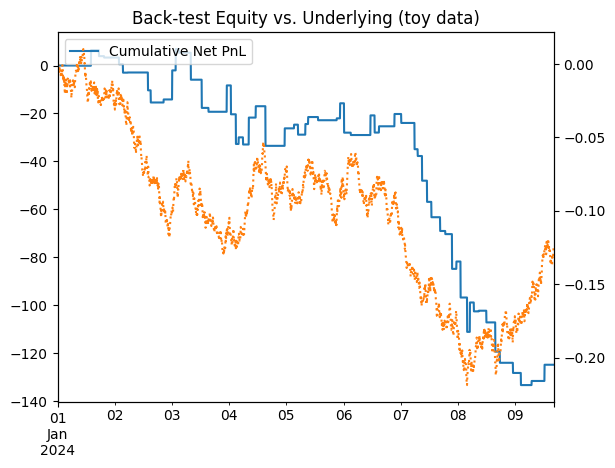

In [28]:
# Basic equity-curve plot – *optional* (comment out if you haven't installed matplotlib)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
equity.plot(ax=ax, label="Cumulative Net PnL")
df["open"].pct_change().cumsum().plot(
    ax=ax, secondary_y=True, style=":", label="Cum log-return"
)
ax.set_title("Back-test Equity vs. Underlying (toy data)")
ax.legend(loc="upper left")
plt.show()